# CS 178 Exploration

In [ ]:
%pip install kagglehub pandas matplotlib -U --quiet
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder


Note: you may need to restart the kernel to use updated packages.


In [12]:
seed = 178
adult_data = pd.read_csv('data/adult.data', header=None)

## Need to import cols, as they are not pre-defined
adult_data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'income']
adult_data = adult_data.replace(' ?', pd.NA) ## Original stored nas as ' ?'

adult_data['income'] = adult_data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0) # Label Classifier

# Get factors, label vector
X = adult_data.drop(columns=['income'])
y = adult_data['income']
X = pd.get_dummies(X, drop_first=True)
y = pd.get_dummies(y, drop_first=True).iloc[:, 0]

n_features = X.shape[1]
print(adult_data.shape)

(32561, 15)


In [14]:
# Encode categorical columns
label_encoders = {}
for col in adult_data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    adult_data[col] = le.fit_transform(adult_data[col].astype(str))
    label_encoders[col] = le

# Separate features and target
X = adult_data.drop(columns=['income'])
y = adult_data['income']

# Calculate F-scores and p-values
f_values, p_values = f_classif(X, y)

# Calculate information gain
def information_gain(X, y, epsilon=1e-10):
    total_entropy = -np.sum([p * np.log2(p + epsilon) for p in np.bincount(y) / len(y)])
    info_gain = []
    for col in X.columns:
        values, counts = np.unique(X[col], return_counts=True)
        weighted_entropy = np.sum([(counts[i] / max(np.sum(counts), 1)) * -np.sum([p * np.log2(p + epsilon) for p in np.bincount(y[X[col] == values[i]]) / max(counts[i], 1)]) for i in range(len(values))])
        res = total_entropy - weighted_entropy
        info_gain.append(res)
    return np.array(info_gain)

info_gain = information_gain(X, y)

# Create a DataFrame to display the results
f_scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_values,
    'Information Gain': info_gain
}).sort_values(by='F-Score', ascending=False)

print(f_scores)

           Feature      F-Score  Information Gain
4    education_num  4120.095780          0.093591
7     relationship  2187.645828          0.165366
0              age  1886.707314          0.099218
12  hours_per_week  1813.386282          0.061002
10    capital_gain  1709.150064          0.120295
9              sex  1593.107907          0.037171
5   marital_status  1346.851776          0.156528
11    capital_loss   754.830452          0.053352
3        education   206.129509          0.093591
8             race   168.934788          0.008378
1        workclass    99.237663          0.021572
13  native_country    17.464773          0.008695
6       occupation     3.799514          0.092922
2           fnlwgt     2.915594          0.568010


In [15]:
for col in X.select_dtypes(include=['number']).columns:
    var = np.var(X[col])
    mean = np.mean(X[col])
    print(f"Column: {col}")
    print(f"Variance: \t {var:.6}\t Mean: \t {mean:.6}")

# Get pi = P(Y = 1)
print(f"Proportion of > 50K Income: {np.mean(y):.6}")

# Compute the F-value and p-value for each feature, toward factor analysis
f_values, p_values = f_classif(X.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col), y)
f_scores = pd.DataFrame({'Feature': X.columns, 'F-Score': f_values, 'p-Value': p_values})
f_scores = f_scores.sort_values(by=['F-Score', 'p-Value'], ascending=False)

print(f_scores)

Column: age
Variance: 	 186.056	 Mean: 	 38.5816
Column: workclass
Variance: 	 2.50277	 Mean: 	 3.37637
Column: fnlwgt
Variance: 	 1.11405e+10	 Mean: 	 1.89778e+05
Column: education
Variance: 	 14.9785	 Mean: 	 10.2982
Column: education_num
Variance: 	 6.61869	 Mean: 	 10.0807
Column: marital_status
Variance: 	 2.26863	 Mean: 	 2.61184
Column: occupation
Variance: 	 18.7364	 Mean: 	 6.42176
Column: relationship
Variance: 	 2.58163	 Mean: 	 1.44636
Column: race
Variance: 	 0.720449	 Mean: 	 3.66586
Column: sex
Variance: 	 0.22137	 Mean: 	 0.669205
Column: capital_gain
Variance: 	 5.45409e+07	 Mean: 	 1077.65
Column: capital_loss
Variance: 	 1.62372e+05	 Mean: 	 87.3038
Column: hours_per_week
Variance: 	 152.454	 Mean: 	 40.4375
Column: native_country
Variance: 	 37.0029	 Mean: 	 36.4709
Proportion of > 50K Income: 0.24081
           Feature      F-Score        p-Value
4    education_num  4120.095780   0.000000e+00
7     relationship  2187.645828   0.000000e+00
0              age  1886.7

In [16]:
for col in adult_data.select_dtypes(include=['object']).columns:
    num_categories = adult_data[col].nunique()
    mode_category = adult_data[col].mode()[0]
    print(f"Column: {col}")
    print(f"Number of Categories: {num_categories}")
    print(f"Most Common Category: {mode_category}")

In [17]:
## Modelling Data Prepping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

## Logistic Regression Model

In [18]:
## Initialize
try:
    # logit_model = LogisticRegression(max_iter=1) # Accuracy: 0.7608
    logit_model = LogisticRegression(max_iter=2000) # Accuracy: 0.8497
except ConvergenceWarning:
    print('Model Converged')

## Fit
logit_model.fit(X_train, y_train)

feature_names = ['Intercept'] + X_train.columns.tolist()
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': [logit_model.intercept_[0]] + logit_model.coef_[0].tolist()
})

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
## Logistic Regression Results
t_accuracy = logit_model.score(X_train, y_train)
print(f"Train Accuracy: {t_accuracy:.4f}")
e_accuracy = logit_model.score(X_test, y_test)
print(f"Eval Accuracy: {e_accuracy:.4f}")


Train Accuracy: 0.8121
Eval Accuracy: 0.8119


## Simple NN

In [20]:
# Define and initialize
model = MLPClassifier(hidden_layer_sizes=(n_features, n_features), activation='logistic', solver='adam', max_iter=50, random_state=seed)

# Fit
model.fit(X_train, y_train)

# Evaluate
# Evaluate
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.7714
Test Accuracy: 0.7740


White-box approaches look more accurate - This feature set has well labeled and ordinal factors, so this makes sense. Lets try some additional models.

In [21]:
# Initialize the Random Forest model
#rf_model = RandomForestClassifier(n_estimators=20, random_state=seed) #Random Forest Test Accuracy: 0.8494
rf_model = RandomForestClassifier(n_estimators=20, random_state=seed)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
rf_train_accuracy = rf_model.score(X_train, y_train)
rf_test_accuracy = rf_model.score(X_test, y_test)
print(f"Random Forest Train Accuracy: {rf_train_accuracy:.4f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.4f}")

Random Forest Train Accuracy: 0.9958
Random Forest Test Accuracy: 0.8572


In [22]:
# Initialize the KNN model with k neighbors
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)

# Train the model
knn_model.fit(X_train, y_train)

# Evaluate the model
# Evaluate the model
knn_train_accuracy = knn_model.score(X_train, y_train)
knn_test_accuracy = knn_model.score(X_test, y_test)
print(f"KNN Train Accuracy: {knn_train_accuracy:.4f}")
print(f"KNN Test Accuracy: {knn_test_accuracy:.4f}")

KNN Train Accuracy: 0.8341
KNN Test Accuracy: 0.7774


## Deeper dive into Random Forests

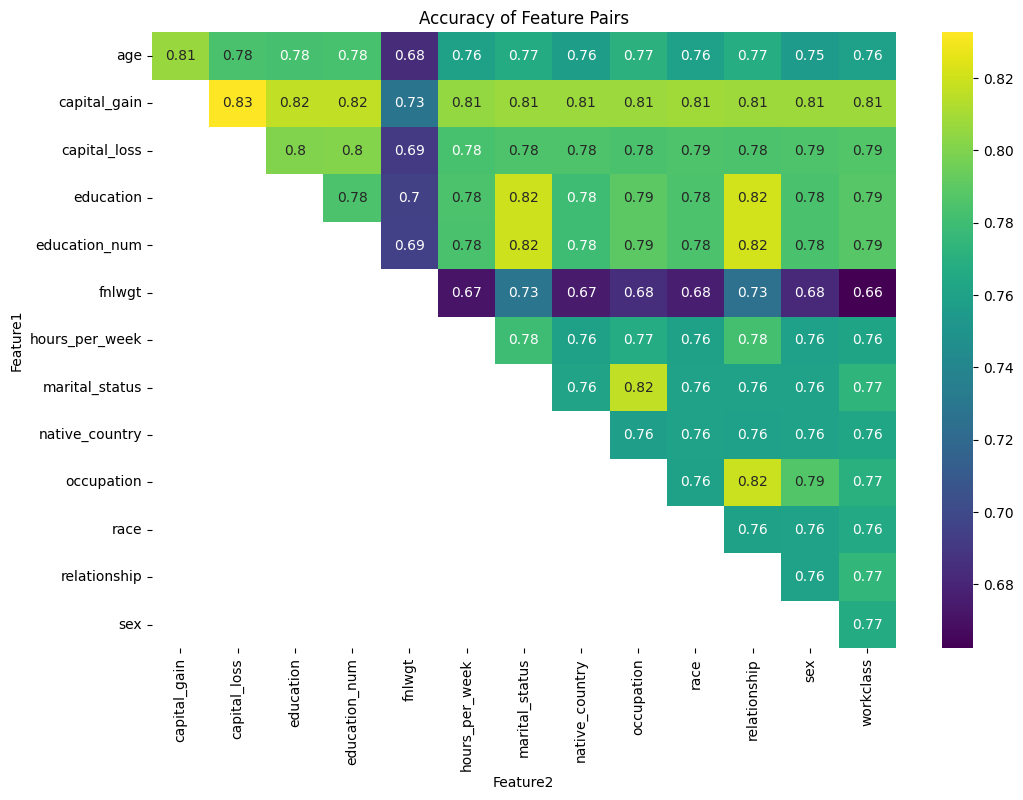

In [23]:
feature_pairs = list(combinations(X_train.select_dtypes(include=[np.number]).columns, 2))
# feature_pairs = list(combinations(X_train.columns, 2))


accuracies = []

# Iterate over each pair of features
for pair in feature_pairs:
    # Subset of X_train with the current pair of features
    X_train_subset = X_train[list(pair)]
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=1, random_state=seed)
    rf_model.fit(X_train_subset, y_train)
    
    # Evaluate the model
    X_test_subset = X_test[list(pair)]
    rf_accuracy = rf_model.score(X_test_subset, y_test)
    
    # Store the accuracy
    accuracies.append((pair, rf_accuracy))

# Plot the accuracies
# Convert accuracies to a DataFrame for easier plotting
accuracy_df = pd.DataFrame(accuracies, columns=['Feature Pair', 'Accuracy'])

# Split the 'Feature Pair' column into two separate columns
# Split the 'Feature Pair' column into two separate columns and sort them
accuracy_df[['Feature1', 'Feature2']] = pd.DataFrame(accuracy_df['Feature Pair'].tolist(), index=accuracy_df.index)
accuracy_df[['Feature1', 'Feature2']] = np.sort(accuracy_df[['Feature1', 'Feature2']], axis=1)

# Pivot the table for heatmap
pivot_table = accuracy_df.pivot(index='Feature1', columns='Feature2', values='Accuracy')

# Plot the accuracies
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar=True)
plt.title('Accuracy of Feature Pairs')
plt.xlabel('Feature2')
plt.ylabel('Feature1')
plt.show()

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

et_model = ExtraTreesClassifier(n_estimators=100, random_state=seed)

et_model.fit(X_train, y_train)

et_train_accuracy = et_model.score(X_train, y_train)
et_test_accuracy = et_model.score(X_test, y_test)

print(f"Extra Trees Train Accuracy: {et_train_accuracy:.4f}")
print(f"Extra Trees Test Accuracy: {et_test_accuracy:.4f}")

Extra Trees Train Accuracy: 1.0000
Extra Trees Test Accuracy: 0.8465


In [25]:
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Initialize the HistGradientBoostingClassifier model
hgb_model = HistGradientBoostingClassifier(random_state=seed,
                                           loss='log_loss',
                                           learning_rate=.1,
                                           l2_regularization=0
                                           ,early_stopping=False)

# Train the model
hgb_model.fit(X_train, y_train)

# Evaluate the model
hgb_train_accuracy = hgb_model.score(X_train, y_train)
hgb_test_accuracy = hgb_model.score(X_test, y_test)
print(f"HistGradientBoostingClassifier Train Accuracy: {hgb_train_accuracy:.4f}")
print(f"HistGradientBoostingClassifier Test Accuracy: {hgb_test_accuracy:.4f}")

HistGradientBoostingClassifier Train Accuracy: 0.8886
HistGradientBoostingClassifier Test Accuracy: 0.8723


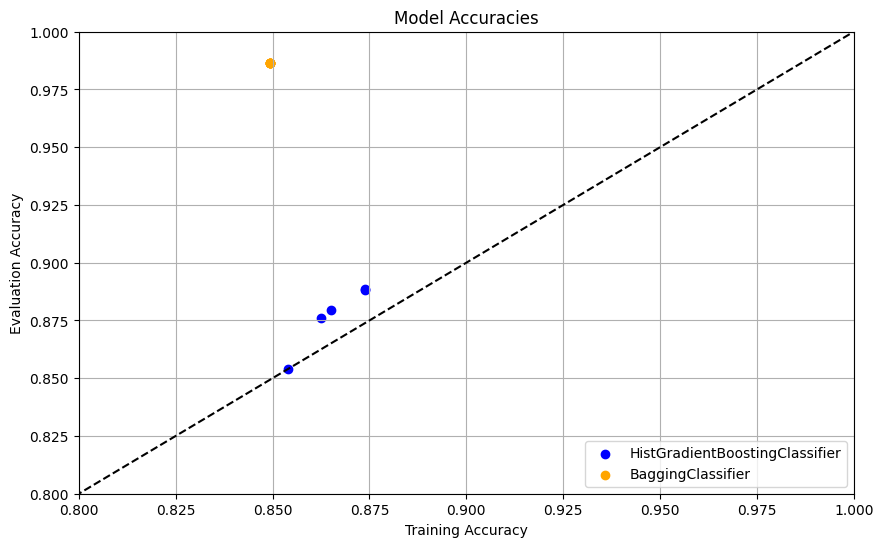

In [ ]:
bagging_train_accuracy = []
bagging_test_accuracy = []
hist_train_accuracy = []
hist_test_accuracy = []
hist_len = 10

for n_estimators in [1, 5, 10, 20, 40, 100, 200]:
    bagging_model = BaggingClassifier(random_state=seed, n_estimators=n_estimators)
    bagging_model.fit(X_train, y_train)

    bagging_train_accuracy.append(bagging_model.score(X_train, y_train))
    bagging_test_accuracy.append(bagging_model.score(X_test, y_test))

for _lr, _bins in [(.01, 255), (.1, 32), (.1, 64), (.1, 128), (.1, 255)]:
    hist_model = HistGradientBoostingClassifier(random_state=seed, learning_rate=_lr, max_bins=_bins)
    hist_model.fit(X_train, y_train)

    hist_train_accuracy.append(hist_model.score(X_train, y_train))
    hist_test_accuracy.append(hist_model.score(X_test, y_test))

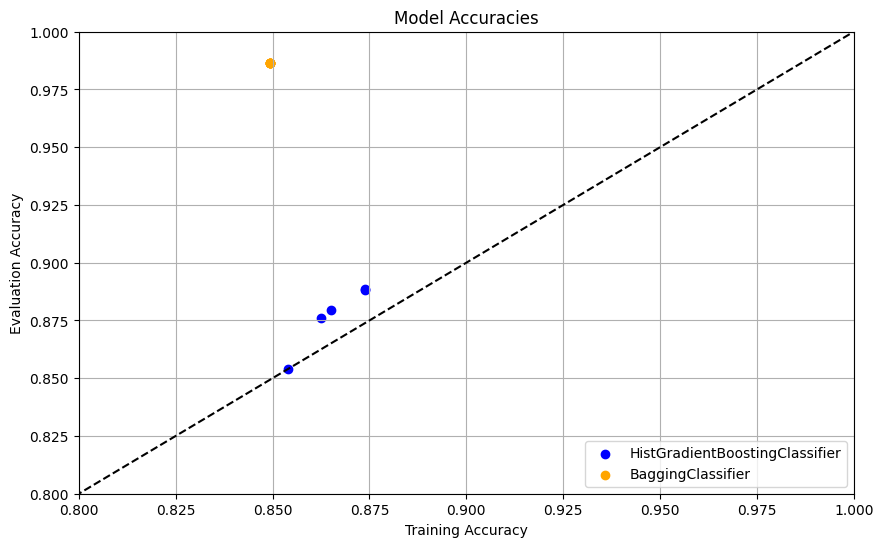

In [45]:
plt.figure(figsize=(10, 6))

## Import lists
plt.scatter(hist_test_accuracy, hist_train_accuracy, color='blue', label='HistGradientBoostingClassifier')
plt.scatter(bagging_test_accuracy, bagging_train_accuracy, color='orange', label='BaggingClassifier')

plt.xlabel('Training Accuracy')
plt.ylabel('Evaluation Accuracy')
plt.title('Model Accuracies')
plt.ylim((.8, 1))
plt.xlim((.8, 1))
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.grid(True)
plt.show()